In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor



Dataset size: (442, 11)
Feature types:
age    float64
sex    float64
bmi    float64
dtype: object
...


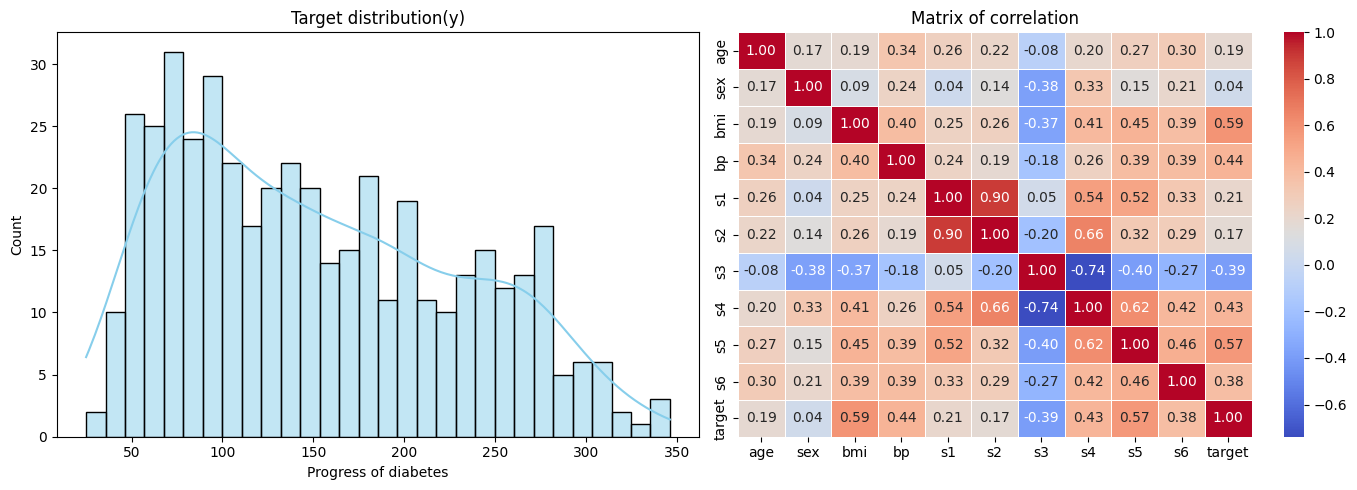

In [2]:
# ==========================================
# 1. Uploading data
# ==========================================
diabetes = load_diabetes(as_frame=True, scaled=False) 
df = diabetes.frame
X_raw = diabetes.data
y = diabetes.target

print(f"Dataset size: {df.shape}")
print(f"Feature types:\n{X_raw.dtypes.head(3)}\n...")

# --- Plots of data ---
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(y, kde=True, bins=30, color='skyblue')
plt.title('Target distribution(y)')
plt.xlabel('Progress of diabetes')

plt.subplot(1, 2, 2)
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Matrix of correlation')

plt.tight_layout()
plt.show()


In [3]:
# ==========================================
# 2. Preprocessing
# ==========================================
scaler = StandardScaler()

X_scaled_np = scaler.fit_transform(X_raw)
X_scaled = pd.DataFrame(X_scaled_np, columns=X_raw.columns)

print("\nChecking dataset after scaling:")
stats = X_scaled.describe().loc[['mean', 'std', 'min', 'max']]
print(stats.round(2))


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f"\nDataset was splited: Train={X_train.shape[0]}, Test={X_test.shape[0]}")


Checking dataset after scaling:
       age   sex   bmi    bp    s1    s2    s3    s4    s5    s6
mean  0.00  0.00  0.00  0.00 -0.00 -0.00 -0.00 -0.00  0.00  0.00
std   1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00
min  -2.25 -0.94 -1.90 -2.36 -2.67 -2.43 -2.15 -1.61 -2.65 -2.90
max   2.33  1.07  3.59  2.78  3.24  4.18  3.81  3.89  2.81  2.85

Dataset was splited: Train=353, Test=89


In [4]:
# ==========================================
# 3. Experiment and searching the best params
# ==========================================
models_config = {
    'BayesianRidge': {
        'model': BayesianRidge(),
        'params': {
            'alpha_1': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3], 
            'lambda_1': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
        }
    },
    'AdaBoost': {
        'model': AdaBoostRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 150, 200, 250],
            'learning_rate': [0.001, 0.01, 0.1, 1.0],
            'loss': ['linear', 'square']
        }
    }
}

if XGBRegressor:
    models_config['XGBoost'] = {
        'model': XGBRegressor(objective='reg:squarederror', random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [3, 4, 5],
            'learning_rate': [0.01, 0.1, 1.0]
        }
    }

results = {}
best_model_global = None
best_r2_global = -np.inf
best_name_global = ""

for name, config in models_config.items():
    print(f"Searching params for {name}...")

    grid = GridSearchCV(config['model'], config['params'], cv=5, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    results[name] = grid
    print(f"  The best params: {grid.best_params_}")
    print(f"  The best R2 score (CV): {grid.best_score_:.4f}")
    
    if grid.best_score_ > best_r2_global:
        best_r2_global = grid.best_score_
        best_model_global = grid.best_estimator_
        best_name_global = name

Searching params for BayesianRidge...
  The best params: {'alpha_1': 1e-07, 'lambda_1': 0.001}
  The best R2 score (CV): 0.4542
Searching params for AdaBoost...
  The best params: {'learning_rate': 0.1, 'loss': 'linear', 'n_estimators': 150}
  The best R2 score (CV): 0.4153
Searching params for XGBoost...
  The best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
  The best R2 score (CV): 0.3786



--- Table for comparation ---
           Model          MSE        MAE  R2 Score
1       AdaBoost  2825.837159  43.382429  0.466637
2        XGBoost  2852.856947  43.943533  0.461537
0  BayesianRidge  2871.759113  42.866026  0.457970


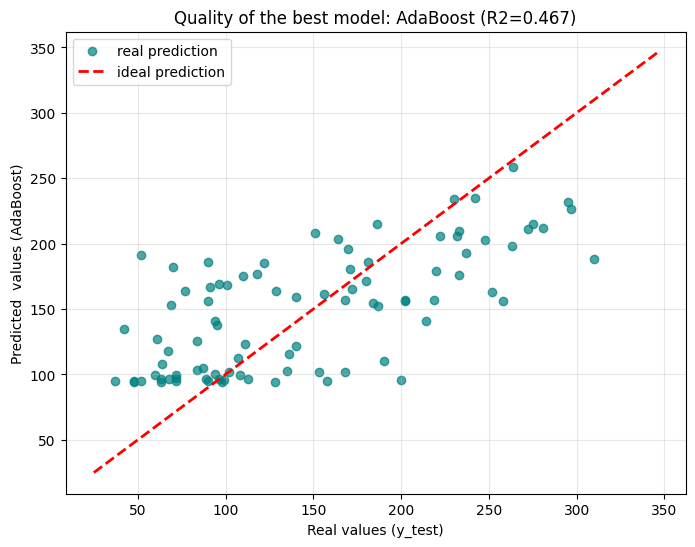

In [5]:
# ==========================================
# 4. Final results and visualization
# ==========================================
print("\n--- Table for comparation ---")
final_metrics = []

for name, grid in results.items():
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    final_metrics.append({
        'Model': name,
        'MSE': mse,
        'MAE': mae,
        'R2 Score': r2
    })

results_df = pd.DataFrame(final_metrics).sort_values(by='R2 Score', ascending=False)
print(results_df)

best_model_name = results_df.iloc[0]['Model'] 
best_r2 = results_df.iloc[0]['R2 Score']

best_model = results[best_model_name].best_estimator_

plt.figure(figsize=(8, 6))
y_pred_best = best_model.predict(X_test)

plt.scatter(y_test, y_pred_best, alpha=0.7, color='teal', label='real prediction')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='ideal prediction')

plt.xlabel('Real values (y_test)')
plt.ylabel(f'Predicted  values ({best_model_name})')
plt.title(f'Quality of the best model: {best_model_name} (R2={best_r2:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
